## Imports

In [1]:
import multiprocessing
import os
import pickle
import time

import energyflow as ef
from energyflow.datasets import mod
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

from pyclustering.cluster import kmedoids
import fastjet as fj

import modplot
import utils

## Load MOD Dataset and EMDs

In [8]:
num4emd_str = '40k'
ptmin, ptmax = (399, 401)
rotate = True
reprocess = True

filtname = 'TracksPFCpTCut'

dset = 'cms'
dset_name = 'CMS 2011 Open Data'
name = 'CMS_Jet300_pT{}-{}GeV_EtaMax19_Quality2_{}'

rot_str = '_Rotated' if rotate else ''
dset_path = 'sim' if dset == 'gen' else dset

lines = {
    'line_0': 'CMS 2011 Open Data',
    'line_1': r'AK5 Jets, $|\eta^{\rm jet}|<1.9$',
    'line_2': r'$p_T^{\rm jet}\in' + '[{},{}]$ GeV'.format(ptmin, ptmax),
    'line_3': r'CHS, $p_T^{\rm PFC}>1$ GeV, Tracks',
    'line_4': 'Rotated, Scaled to 400 GeV',
}

pt_cut = 1.0
R = 0.5
filters = {
    'All': {'which': 'all', 'pt_cut': None, 'chs': True},
    'PFCpTCut': {'which': 'all', 'pt_cut': pt_cut, 'chs': True},
    'Tracks': {'which': 'charged', 'pt_cut': None, 'chs': True},
    'TracksPFCpTCut': {'which': 'charged', 'pt_cut': pt_cut, 'chs': True},
}

In [9]:
#for dset,name in zip(dsets, names):
start = time.time()

name = name.format(ptmin, ptmax, num4emd_str)
dset_path = (dset if dset != 'gen' else 'sim')
modds = mod.MODDataset(name, path=utils.path(dset_path, 'h5'))

emd_name = '{}_{}{}'.format(name, filtname, rot_str)
emds = np.load(utils.path(dset_path, 'emds', emd_name + '.npy'))

if np.any(emds < 0):
    pos_mask = ~np.all(emds <= 0, axis=0)
    emds = emds[pos_mask][:,pos_mask]
    
    modds.apply_mask(pos_mask)

print('Loaded MODDataset and EMDs for {} in {:.3f}s'.format(emd_name, time.time() - start))

Loaded MODDataset and EMDs for CMS_Jet300_pT399-401GeV_EtaMax19_Quality2_40k_TracksPFCpTCut_Rotated in 35.737s


## Filter Particles

In [10]:
start = time.time()

particles = []
for i in range(len(modds)):
    particles_i = modds.particles[i]
    
    particles_i = particles_i[utils.filter_particles(particles_i, **filters[filtname]),:3]
    particles_i = ef.rotate_ptyphims(particles_i, center='escheme')
    particles_i = particles_i[np.linalg.norm(particles_i[:,1:3], axis=1) <= R]
    particles_i[:,0] *= 400./particles_i[:,0].sum()
    
    particles.append(particles_i)
    
print('Finished filtering particles in {:.3f}s'.format(time.time() - start))

Finished filtering particles in 14.390s


## Observables

In [18]:
def to_pjs(event):
    pjs = []
    for particle in event:
        pj = fj.PseudoJet()
        pj.reset_PtYPhiM(*particle)
        pjs.append(pj)
    return pjs

def to_CA_jet(jet_consts):
    CA_def = fj.JetDefinition(fj.cambridge_aachen_algorithm, fj.JetDefinition.max_allowable_R)
    CA_jets = CA_def(jet_consts)
    assert len(CA_jets) == 1
    return CA_jets[0]

zcut, R = 0.1, 0.5
def softdrop_beta0(CA_jet):
    parent1, parent2 = fj.PseudoJet(), fj.PseudoJet()
    if not CA_jet.has_parents(parent1, parent2):
        return CA_jet
    
    pt1, pt2 = parent1.pt(), parent2.pt()
    if min(pt1, pt2)/(pt1 + pt2) >= zcut:
        return CA_jet
    else:
        return softdrop_beta0(parent1 if pt1 > pt2 else parent2)
    
zcut, R = 0.1, 0.5
def softdrop_betam1(CA_jet):
    parent1, parent2 = fj.PseudoJet(), fj.PseudoJet()
    if not CA_jet.has_parents(parent1, parent2):
        return CA_jet
    
    pt1, pt2 = parent1.pt(), parent2.pt()
    if min(pt1, pt2)/(pt1 + pt2) >= zcut * R/parent1.delta_R(parent2):
        return CA_jet
    else:
        return softdrop_betam1(parent1 if pt1 > pt2 else parent2)
    
def zg(sd_jet):
    parent1, parent2 = fj.PseudoJet(), fj.PseudoJet()
    if not sd_jet.has_parents(parent1, parent2):
        return 0.
    
    pt1, pt2 = parent1.pt(), parent2.pt()
    return min(pt1, pt2)/(pt1 + pt2)

e2 = ef.EFP([(0,1)], measure='hadr', beta=1, check_input=False)
e3 = ef.EFP([(0,1), (1,2), (0,2)], measure='hadr', beta=1, check_input=False)

bins_around_zero = np.linspace(-0.5, 0.5, 34)

def obs_from_particles(i, reg=10**-30):
    
    # mask particles
    particles_i = particles[i]
    
    # compute masses
    pt_tot, y_tot, phi_tot, mass = ef.sum_ptyphims(particles_i)
    
    # mults are easy
    mult = len(particles_i)
    
    # ptd
    ptd = np.sqrt(np.sum(particles_i[:,0]**2))/(np.sum(particles_i[:,0]) + reg)
    
    # N95
    pixels = np.histogram2d(particles_i[:,1], particles_i[:,2], weights=particles_i[:,0], 
                            bins=(y_tot + bins_around_zero, phi_tot + bins_around_zero))[0].flatten()
    n95 = np.argmax(np.cumsum(np.sort(pixels/(pixels.sum() + reg))[::-1]) >= 0.95) + 1
    
    # z_g
    if mult:
        ca_jet = to_CA_jet(to_pjs(particles_i))
        zg_val0 = zg(softdrop_beta0(ca_jet))
    else:
        zg_val0 = 0.
    
    # D2
    d2 = np.log(e3.compute(particles_i)/(e2.compute(particles_i)**3 + reg) + reg)
    
    return (mass, mult, ptd, n95, zg_val0, d2)

In [19]:
ob_names = ['TrackMass', 'TrackMult', 'TrackpTD', 'TrackN95', 'Trackzg0', 'TrackD2', 
            'TrackEMDn05', 'TrackEMDn10', 'TrackEMDn20']
obs = {name: {} for name in ob_names}

start = time.time()

# calculate observables
with multiprocessing.Pool(processes=None) as pool:
    obs_vals = np.asarray(list(pool.map(obs_from_particles, np.arange(len(particles))))).T

# store values
for i,ob_name in enumerate(ob_names):
    if 'EMD' in ob_name:
        continue
        
    obs[ob_name]['values'] = obs_vals[i]

print('completed in {:.3f}s'.format(time.time() - start))

completed in 13.239s


In [20]:
emd_ob_names = [('TrackEMDn05', 0.5), ('TrackEMDn10', 1), ('TrackEMDn20', 2)]

for name,n in emd_ob_names:
    start = time.time()
    obs[name]['values'] = np.average(emds**n, weights=modds.weights, axis=1)**(1/n)
    print(name, 'finished in {:.3f}s'.format(time.time() - start))

TrackEMDn05 finished in 19.425s
TrackEMDn10 finished in 18.299s
TrackEMDn20 finished in 18.097s


In [50]:
# the jet track mass
obs['TrackMass'].update({
    'nbins': 12,
    'xlabel': r'Track Mass $m_\text{track}$ [GeV]', 
    'ylabel': 'Differential Cross Section [pb/GeV]',
    'xlim': (0, 120), 
    'xtick_step': 20, 'ytick_step': 0.1,
    'tx': 36.5, 'ty': 252,
})

# the track constituent multiplicity
obs['TrackMult'].update({
    'nbins': 10,
    'xlabel': r'Track Multiplicity $M_{\text{track}}$', 
    'ylabel': 'Differential Cross Section [pb]',
    'xlim': (0, 50), 
    'xtick_step': 5, 'ytick_step': 0.2,
    'tx': 36.5, 'ty': 251,
})

# the track transverse momentum dispersion
obs['TrackpTD'].update({
    'nbins': 10,
    'xlabel': r'Track Transverse Momentum Dispersion $p_{T,\text{track}}^D$', 
    'ylabel': 'Differential Cross Section [pb]',
    'xlim': (0, 1), 
    'xtick_step': 0.2, 'ytick_step': 10,
    'tx': 33.75, 'ty': 254.7,
})

# Track N95
obs['TrackN95'].update({
    'nbins': 10,
    'xlabel': r'Track Image Activity $N_{95,\text{track}}$', 
    'ylabel': 'Differential Cross Section [pb]',
    'xlim': (0, 40), 
    'xtick_step': 10, 'ytick_step': 0.25,
    'tx': 41.5, 'ty': 252,
})

# Track z_g
obs['Trackzg0'].update({
    'nbins': 10,
    'xlabel': r'Track Groomed Momentum Fraction $z_{g,\text{track}}$', 
    'ylabel': 'Differential Cross Section [pb]',
    'xlim': (0, 0.5), 
    'xtick_step': 0.1, 'ytick_step': 20,
    'tx': 38.75, 'ty': 252,
})

# Track D2
obs['TrackD2'].update({
    'nbins': 10,
    'xlabel': r'Track $\ln D_{2,\text{track}}$', 
    'ylabel': 'Differential Cross Section [pb]',
    'xlim': (-1.5, 3), 
    'xtick_step': 0.45, 'ytick_step': 5,
    'tx': 33.75, 'ty': 252,
    'ymax': 2.55,
})

# Track EMD Moment 0.5
obs['TrackEMDn05'].update({
    'nbins': 12,
    'xlabel': r'EMD to Dataset $\overline{Q}_{0.5,\text{track}}$ [GeV]', 
    'ylabel': 'Differential Cross Section [pb/GeV]',
    'xlim': (30, 210), 'ylim': (10**-4, 250),
    'xtick_step': 30,
    'tx': 44.4, 'ty': 254.6,
})

# Track EMD Moment 1
obs['TrackEMDn10'].update({
    'nbins': 12,
    'xlabel': r'Mean EMD to Dataset $\overline{Q}_{1,\text{track}}$ [GeV]', 
    'ylabel': 'Differential Cross Section [pb/GeV]',
    'xlim': (30, 210), 'ylim': (10**-4, 250),
    'xtick_step': 30,
    'tx': 44.4, 'ty': 254.6,
})

# Track EMD Moment 2
obs['TrackEMDn20'].update({
    'nbins': 12,
    'xlabel': r'EMD to Dataset $\overline{Q}_{2,\text{track}}$ [GeV]', 
    'ylabel': 'Differential Cross Section [pb/GeV]',
    'xlim': (30, 210), 'ylim': (10**-4, 250),
    'xtick_step': 30,
    'tx': 44.4, 'ty': 254.6,
})

## k-Medoids

In [37]:
# specify number of medoids
k = 4
verbose = True

def get_kmedoids(key):
    
    if verbose:
        print('Running kmedoids for', key)
        
    ob_start = time.time()
    
    ob = obs[key]
    meds = {}

    # make bins
    meds['bins'] = bins = np.linspace(*ob['xlim'], ob['nbins'] + 1)
    
    initials, medoids = np.zeros((len(bins)-1, k), dtype=int), np.zeros((len(bins)-1, k), dtype=int)
    for i in range(len(bins)-1):
        mask = (ob['values'] >= bins[i]) & (ob['values'] < bins[i+1])
        dists_i = emds[mask][:,mask]

        if len(dists_i) < k:
            initials[i] = medoids[i] = -1
            continue
                
        c = 0
        while len(np.unique(medoids[i])) != k:
            start = time.time()
            if c > 0:
                print('  {}: medoids not unique, rerunning bin {}, iteration {}'.format(key, i, c+1))

            initials[i] = np.random.randint(len(dists_i), size=k)
            kmeds = kmedoids.kmedoids(dists_i, initials[i], data_type='distance_matrix', tolerance=0.0001)
            kmeds.process()

            medoids[i] = np.nonzero(mask)[0][kmeds.get_medoids()]

            c += 1
        
        if verbose:
            args = (key, i, len(dists_i), time.time() - start)
            print('  {}: bin {} with {} jets finished in {:.3f}s'.format(*args))
        
    meds['initials'] = initials
    meds['medoids'] = medoids
        
    if verbose:
        print('{}: finished in {:.3f}s'.format(key, time.time() - ob_start))
        print()
        
    return meds
        
start = time.time()

# calculate observables
ob_calc_names = ['TrackEMDn05', 'TrackEMDn10', 'TrackEMDn20']
    #['TrackMass', 'TrackMult', 'TrackpTD', 'TrackN95', 'Trackzg0', 'TrackD2']
with multiprocessing.Pool(processes=len(ob_calc_names)) as pool:
    for ob_name,meds in zip(ob_calc_names, pool.map(get_kmedoids, ob_calc_names)):
        obs[ob_name].update(meds)

print('Completed k-Medoids in {:.3f}s'.format(time.time() - start))
    
name = 'kMedoids_obs_{}-{}GeV.pickle'.format(ptmin, ptmax)
with open(os.path.join(utils.DATAPATH, 'plotdata', name), 'wb') as f:
    pickle.dump(obs, f)

Running kmedoids for EMDn05
Running kmedoids for EMDn10
Running kmedoids for EMDn20
  EMDn10: bin 0 with 97 jets finished in 0.027s
  EMDn20: bin 1 with 11648 jets finished in 74.859s
  EMDn05: bin 0 with 13719 jets finished in 89.252s
  EMDn05: bin 1 with 10919 jets finished in 51.235s
  EMDn05: bin 2 with 3749 jets finished in 5.807s
  EMDn05: bin 3 with 2099 jets finished in 1.421s
  EMDn05: bin 4 with 1320 jets finished in 0.394s
  EMDn05: bin 5 with 888 jets finished in 0.450s
  EMDn05: bin 6 with 589 jets finished in 0.224s
  EMDn05: bin 7 with 425 jets finished in 0.116s
  EMDn05: bin 8 with 196 jets finished in 0.038s
  EMDn05: bin 9 with 59 jets finished in 0.012s
  EMDn05: bin 10 with 15 jets finished in 0.011s
  EMDn05: medoids not unique, rerunning bin 11, iteration 2
  EMDn05: medoids not unique, rerunning bin 11, iteration 3
  EMDn05: medoids not unique, rerunning bin 11, iteration 4
  EMDn05: medoids not unique, rerunning bin 11, iteration 5
  EMDn05: medoids not unique,

## Plots

In [42]:
#name = 'kMedoids_obs_{}-{}GeV.pickle'.format(ptmin, ptmax)
#with open(os.path.join(utils.DATAPATH, 'plotdata', name), 'wb') as f:
#    pickle.dump(obs, f)

In [43]:
name = 'kMedoids_obs_{}-{}GeV.pickle'.format(ptmin, ptmax)
obs = np.load(os.path.join(utils.DATAPATH, 'plotdata', name), allow_pickle=True)

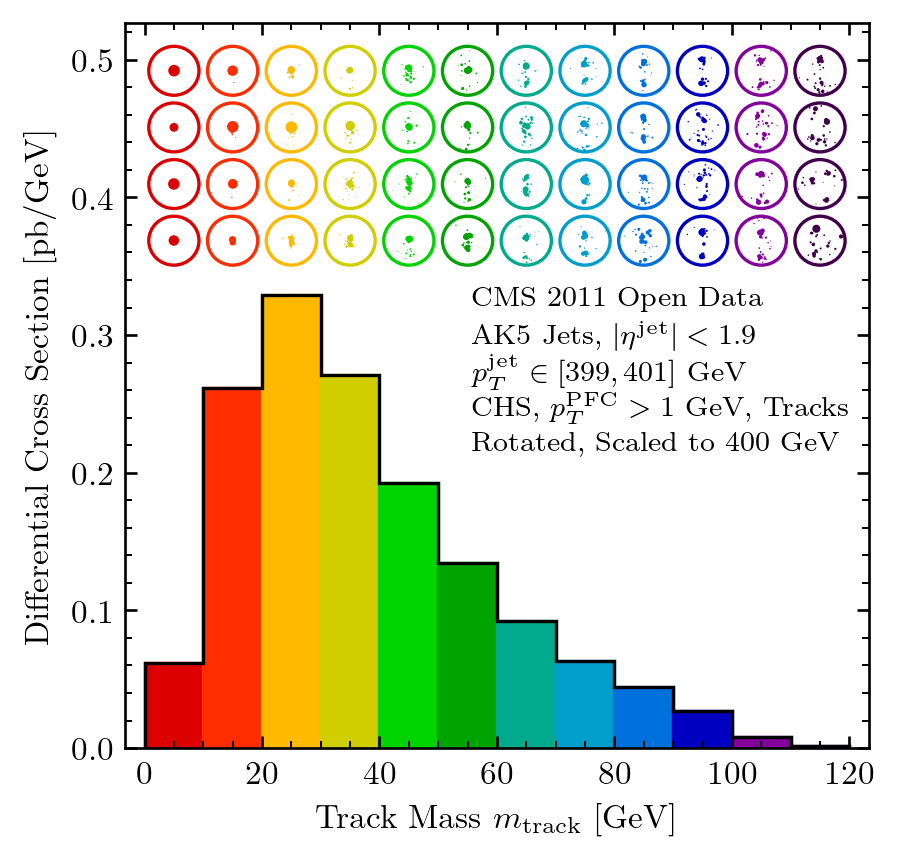

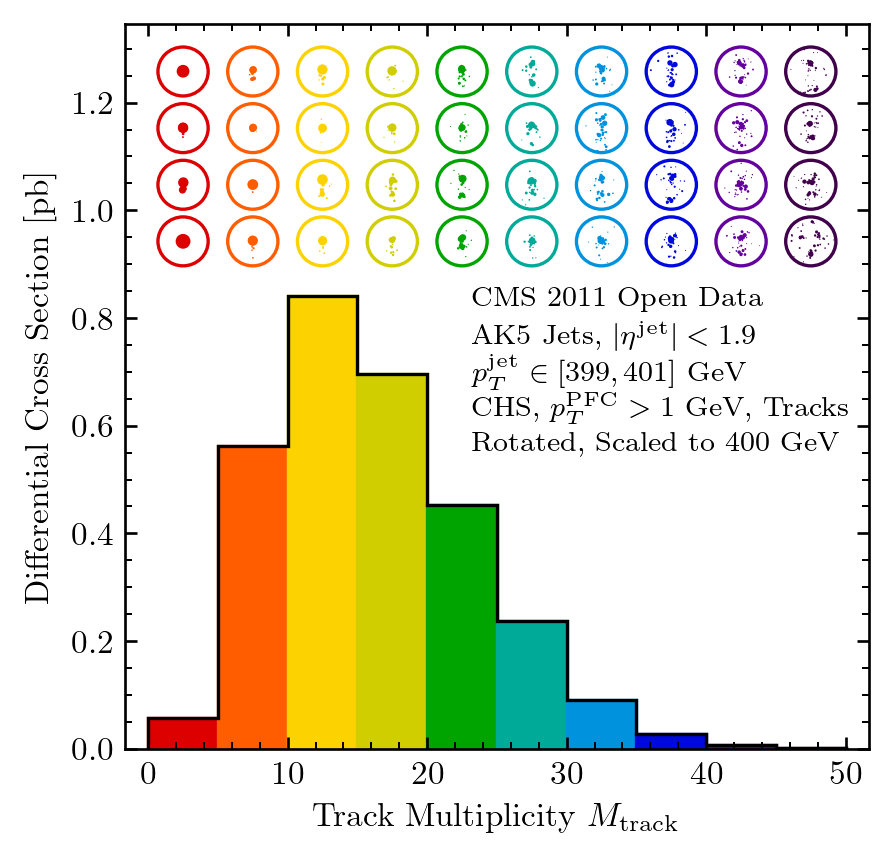

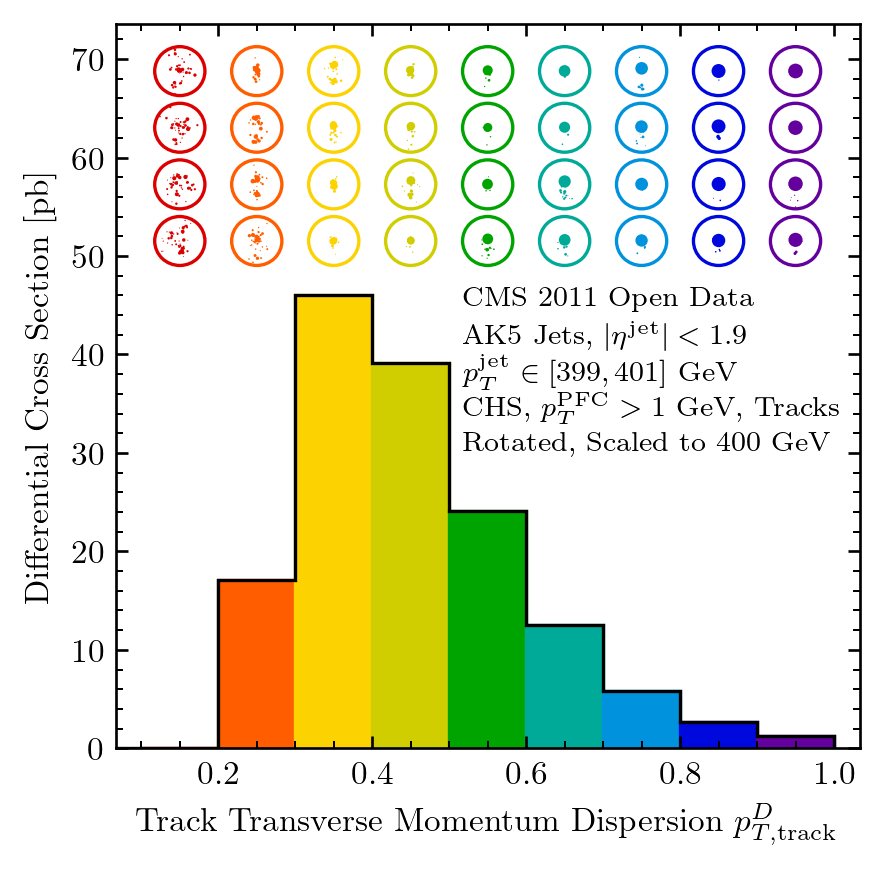

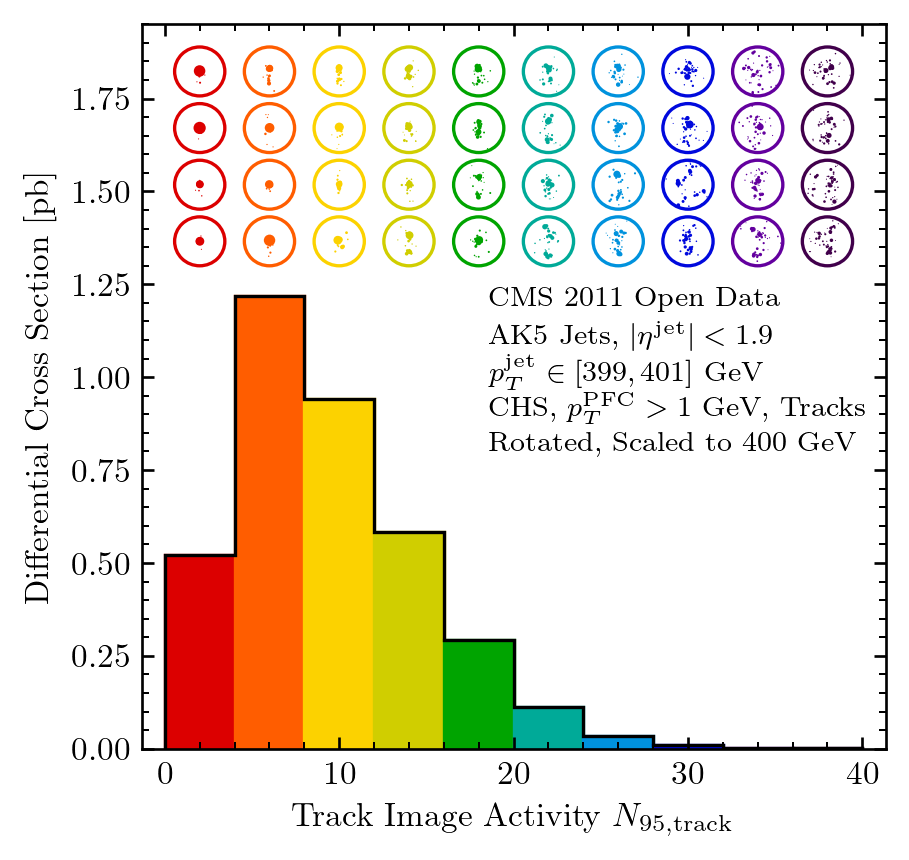

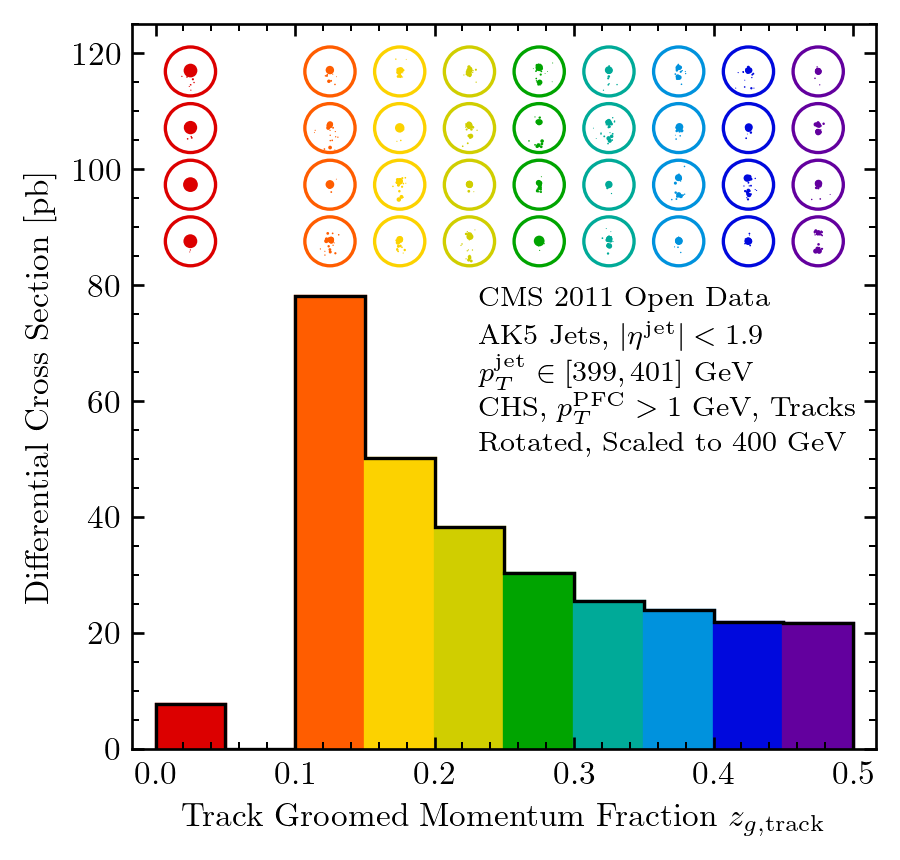

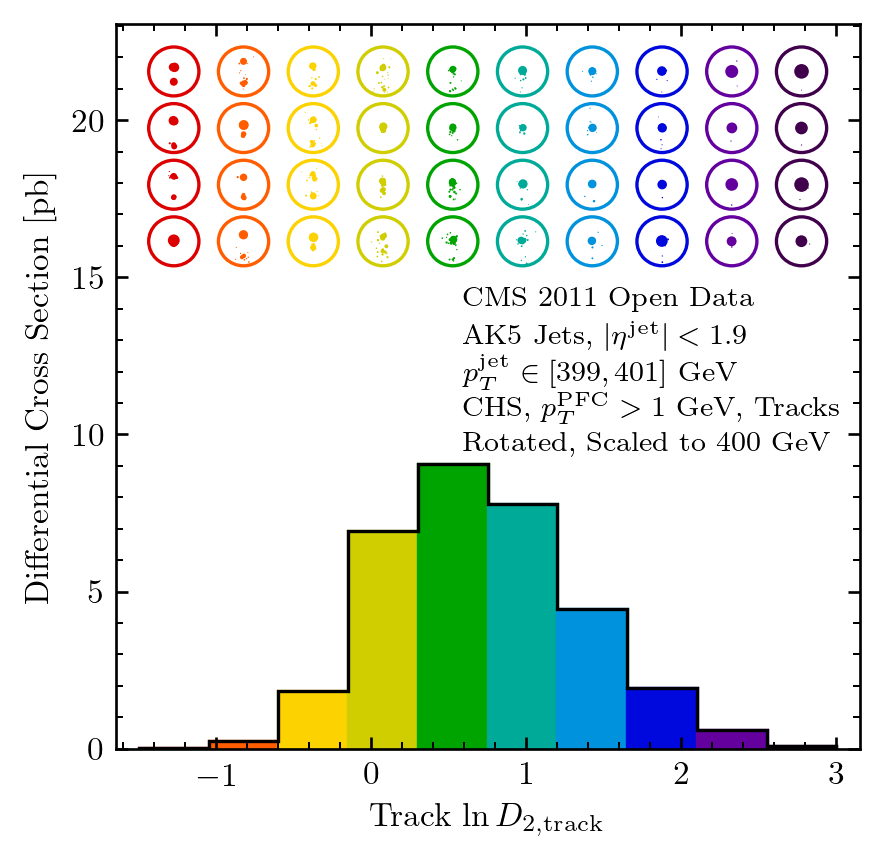

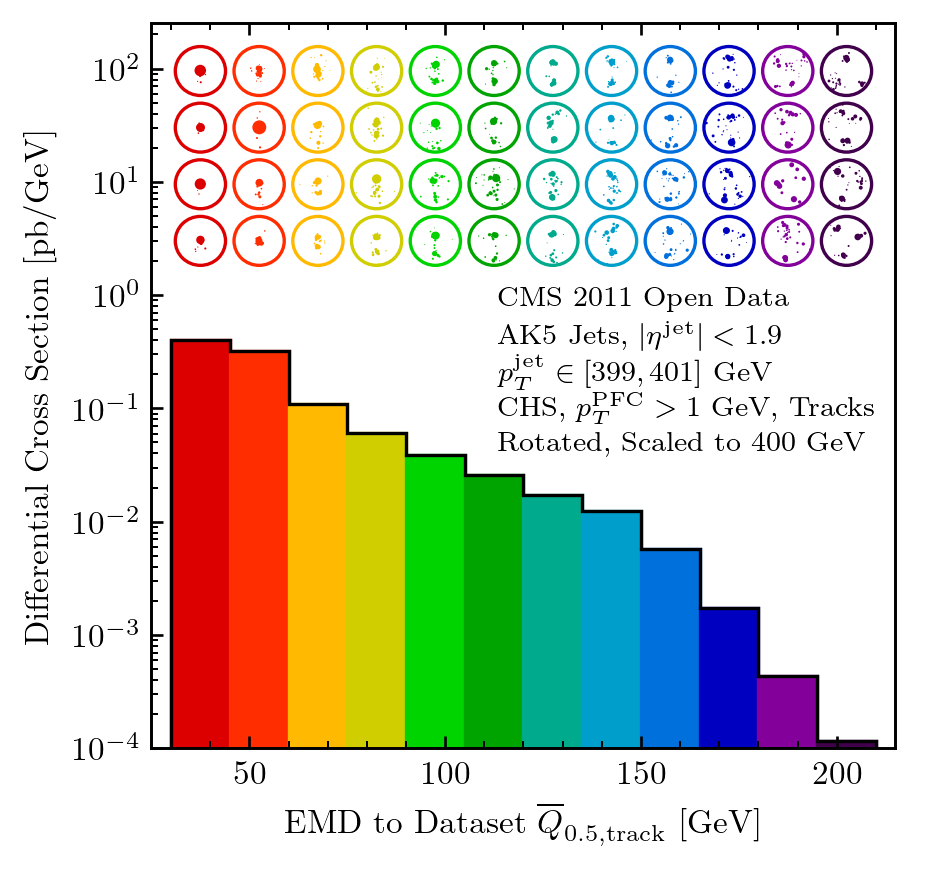

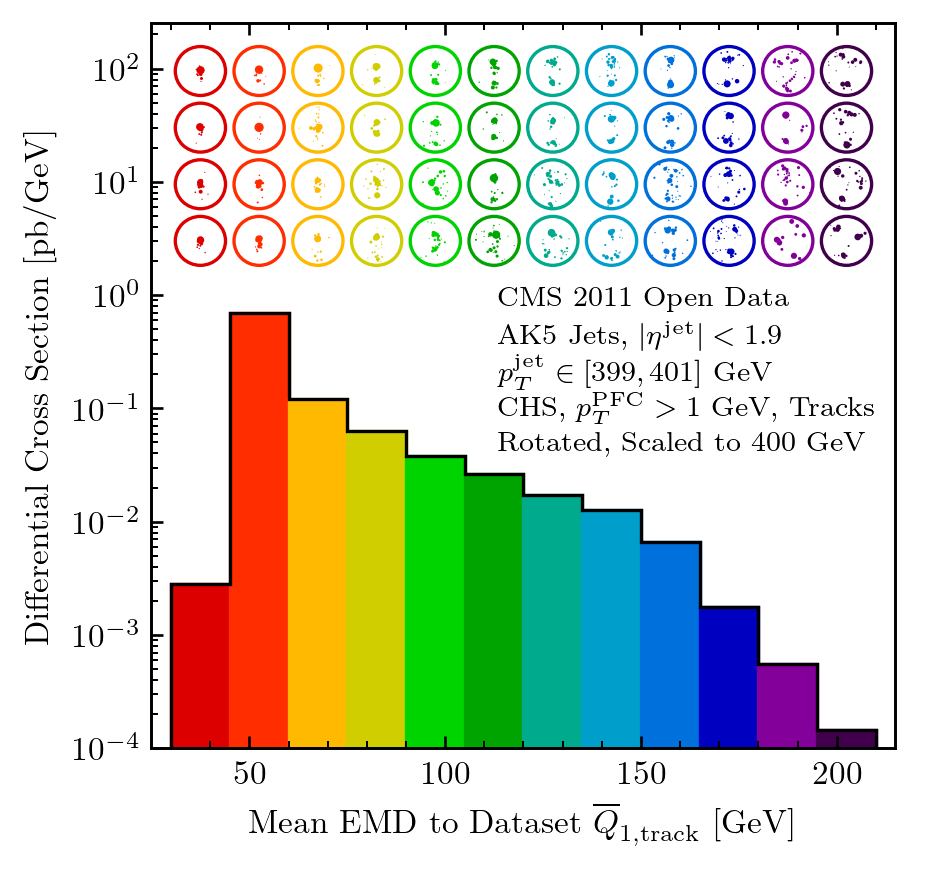

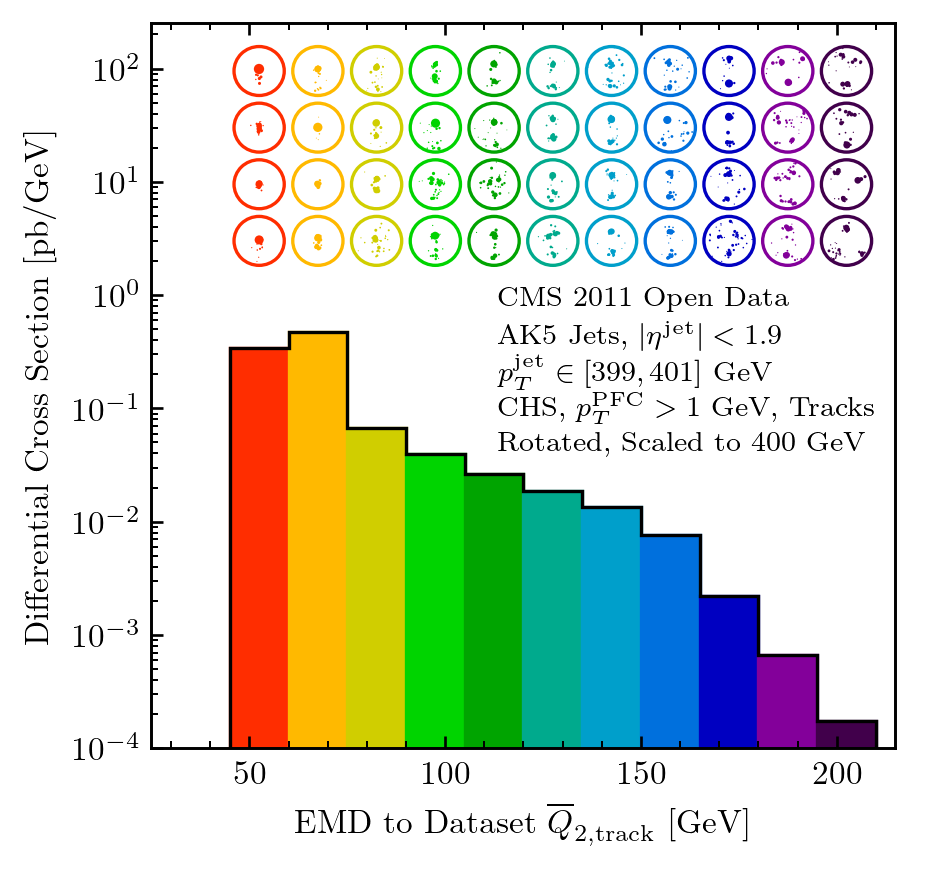

In [51]:
yoff, dy, ymax = 0.7, 0.078125, 1.6
zf = 0.05
R = 0.5
r = 0.03375

for key,ob in obs.items():

    # make the histogram and associated scatterplots
    bins = ob['bins']
    dx = bins[1] - bins[0]
    midbins = (bins[1:] + bins[:-1])/2

    xmin, xmax = bins[0] - dx/3, bins[-1] + dx/3
    if key == 'TrackpTD':
        xmin += dx
    fig, [ax] = modplot.axes(ratio_plot=False,
                             xlabel=ob['xlabel'], ylabel=ob['ylabel'],
                             xlim=(xmin, xmax))
    
    if 'EMD' in key:
        ax2 = ax.twinx()
        ax2.set_yticks([])
        ax.set_yscale('log')

    cmap = matplotlib.cm.get_cmap('nipy_spectral')

    # note the weights/dx to normalize correctly
    obs_hist, _, _ = ax.hist(ob['values'], bins=bins, weights=modds.weights/dx*1000,
                                  histtype='step', density=False, color='black', zorder=10)
    
    ymax_local = ob['ymax'] if 'ymax' in ob else ymax
    axm = ax2 if 'EMD' in key else ax
    axm.set_ylim(0, ymax_local*max(obs_hist))
    
    if 'EMD' in key:
        ax.set_ylim(*ob['ylim'])
        ax2.set_ylim(0, ymax_local*max(obs_hist))

    rx= r*(xmax - xmin)
    ry= r*max(obs_hist)*ymax_local

    nskip = 0
    for i,(x0,meds) in enumerate(zip(midbins, ob['medoids'])):
        if meds[0] == -1:
            nskip += 1
            continue
            
        for j,med in enumerate(meds):

            jet = particles[med]
            mask = np.linalg.norm(jet[:,1:3], axis=1) <= R
            zs, yphis = jet[mask,0], jet[mask,1:3]

            y0 = (yoff + j*dy)*max(obs_hist)*ymax_local

            n = i - nskip if 'EMD' not in key else i
            if n != 3:
                cind = 0.9-n/len(midbins)*0.8 if n < 4 else 0.9-(n+1)/len(midbins)*0.87   
                color = cmap(cind)
            else:
                color = (0.93591/1.15, 0.92807/1.15, 0, 1.0)

            axm.scatter(x0 + rx*(yphis[:,0])/R, y0 + ry*(yphis[:,1])/R, s=zf*zs, lw=0, color=color)
            axm.add_patch(matplotlib.patches.Ellipse((x0, y0), 2*rx, 2*ry, fill=False, 
                                                              edgecolor=color, lw=1, zorder=10))

        ax.add_patch(matplotlib.patches.Rectangle((x0 - dx/2, 0), dx, obs_hist[i], color=color))

    modplot.stamp(0.465, 0.62, delta_y=0.05, ax=ax, **lines)
    
    modplot.save(fig, key, out_plots_dir='../plots/kMedoids/', tx=ob['tx'], ty=ob['ty'])
    fig.show()    

## Event Numbers of Most Anomalous Events

In [61]:
print('n = 0.5:', modds.evns[np.argsort(obs['EMDn05']['values'])[::-1][:5]])
print('n = 1:', modds.evns[np.argsort(obs['EMDn10']['values'])[::-1][:5]])
print('n = 2:', modds.evns[np.argsort(obs['EMDn20']['values'])[::-1][:5]])
print('jet pts:', modds.corr_jet_pts[np.argsort(obs['EMDn20']['values'])[::-1][:5]])

n = 0.5: [ 105923515  132512783 1797462977   28303680  254752925]
n = 1: [ 105923515  132512783 1797462977   28303680  254752925]
n = 2: [ 105923515  132512783 1797462977   28303680  254752925]
jet pts: [399.70309494 400.57073121 399.64205787 399.76699093 399.70490906]


## k-Medoids All

In [50]:
def medoids_loss(inds):
    return np.mean(np.min(emds[inds], axis=0))

# random losses
def random_loss(i):
    np.random.seed(i)
    return medoids_loss(np.random.randint(len(emds), size=25))

if reprocess and 0:
    
    path = os.path.join(utils.DATAPATH, 'plotdata', 'kmedoids')
    files = [f for f in os.listdir(path) if dset.upper() in f]

    medoids_k25 = []
    for file in files:
        medoids_k25.append(np.load(os.path.join(path, file), allow_pickle=True))

    # medoids loss
    #medoids_k25_losses = []
    #for medoids in medoids_k25:
    #    medoids_k25_losses.append(medoids_loss(medoids))

    start = time.time()
    with multiprocessing.Pool(processes=44) as pool:
        random_losses = []
        for i,rl in enumerate(pool.imap_unordered(random_loss, range(100000))):
            random_losses.append(rl)
            if (i+1) % 5000 == 0:
                print('Calculated {} random losses in {:.3f}s'.format(i+1, time.time() - start))

    with open(os.path.join(utils.DATAPATH, 'plotdata', 'MeanEMDtoMedoid.pickle'), 'wb') as f:
        pickle.dump({'medoids_k25_losses': medoids_k25_losses, 'random_losses': random_losses}, f)
        print('Saved data')
        
else:
    
    f = np.load(os.path.join(utils.DATAPATH, 'plotdata', 'MeanEMDtoMedoid.pickle'), allow_pickle=True)
    medoids_k25_losses, random_losses = f['medoids_k25_losses'], f['random_losses']
    print('Loaded data')

Loaded data


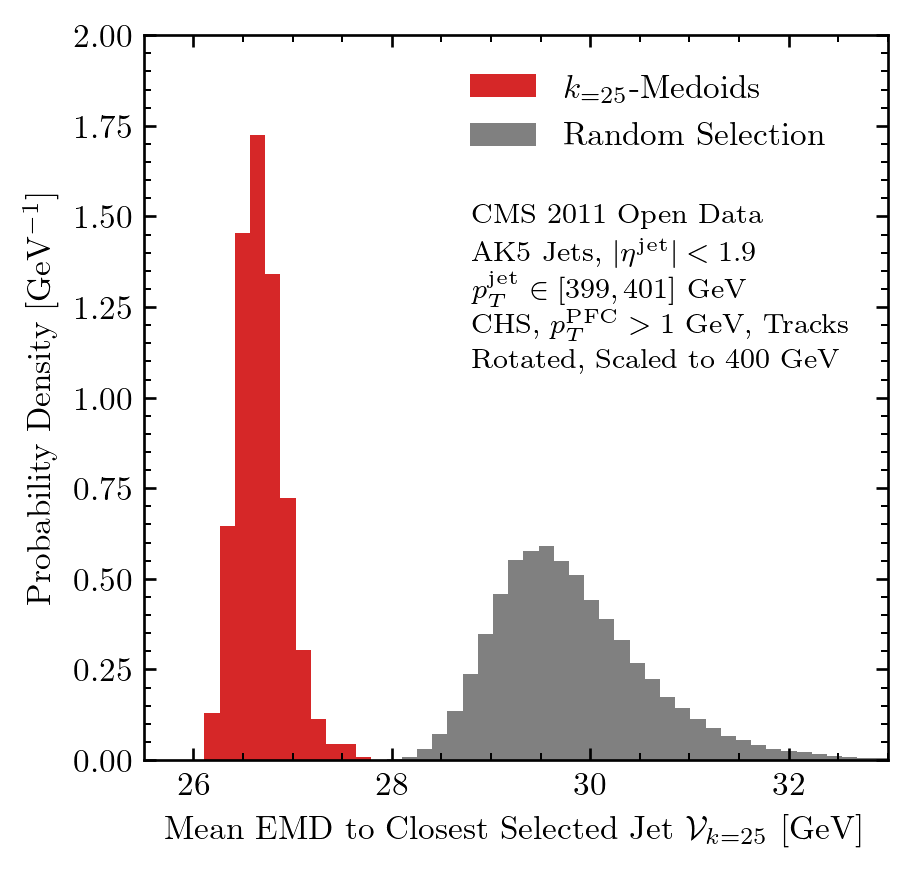

In [51]:
bins = np.linspace(25.5, 33, 50)

fig, [ax] = modplot.axes(ratio_plot=False,
                         xlabel=r'Mean EMD to Closest Selected Jet $\mathcal V_{k=25}$ [GeV]', 
                         ylabel=r'Probability Density [GeV$^{-1}$]',
                         xlim=(min(bins), max(bins)), ylim=(0, 2))
    
ax.hist(medoids_k25_losses[:750], bins=bins, color='tab:red', density=True, label=r'$k_{=25}$-Medoids')
ax.hist(random_losses, bins=bins, color='gray', density=True, label='Random Selection')

ax.legend(loc=(0.42, 0.82), frameon=False)
modplot.stamp(0.44, 0.75, delta_y=0.05, ax=ax, **lines)

#modplot.save(fig, 'MeanEMDtoMedoid', out_plots_dir='../plots/kMedoids', tx=42.15, ty=252)
fig.show()